In [1]:
%matplotlib inline

import os
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('./data/tweets.csv')
df.head()

,author_id,author_name,date,emails,hashtags,language,likes,location,mentions,quotes,retweets,sentiment,source,text,time
0,@Acutoronto,Acutoronto,"Mar 27, 2022",NaN,"motivation,acutoronto,acupuncture,tcm,fertilit...",en,0,NaN,NaN,0.0,0.0,positive,LaterMedia,Sunday #motivation. \n\n#acutoronto #acupunctu...,3:05 PM
1,@LorraineZiff,Lorraine Ziff,"Mar 26, 2022",NaN,"lorraineziff,dearlorraine,smile,friendship,lua...",en,5,NaN,larryziff,0.0,2.0,positive,Twitter for iPhone,Luau Ready! 😎💕 #lorraineziff #dearlorraine @la...,3:19 AM
2,@ImpactWellness,Chris Caito,"Mar 27, 2022",NaN,"MuhammadAli,john316,isaiah4031,philippians413,...",en,0,NaN,NaN,0.0,0.0,positive,Twitter for Android,"“I hated every minute of training, but I said,...",3:02 PM
3,@hiromiyoshihair,Hiro Miyoshi,"Mar 27, 2022",NaN,"mothersday,grateful,thankful",en,0,"London, England",NaN,0.0,0.0,positive,"London, England",To all the mothers - we are greateful! Wishing...,12:55 PM
4,@lunaxbrightwin,Liz lvs Joy,"Mar 27, 2022",NaN,"WildsideOutNow,JOY,RedVelvet",en,6,NaN,RVsmtown0,0.0,0.0,positive,Twitter for Android,"JOY, ERES LA MUJER MÁS TALENTOSA QUE EXISTE 😭\...",3:16 PM


In [3]:
df.shape

(5239, 15)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
emails,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quotes,4287.0,0.047352,0.650817,0.0,0.0,0.0,0.0,22.0
retweets,4287.0,0.738978,6.043413,0.0,0.0,0.0,0.0,275.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5239 entries, 0 to 5238
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   author_id    5229 non-null   object 
 1   author_name  5229 non-null   object 
 2   date         4287 non-null   object 
 3   emails       0 non-null      float64
 4   hashtags     4228 non-null   object 
 5   language     4284 non-null   object 
 6   likes        4287 non-null   object 
 7   location     154 non-null    object 
 8   mentions     1075 non-null   object 
 9   quotes       4287 non-null   float64
 10  retweets     4287 non-null   float64
 11  sentiment    4284 non-null   object 
 12  source       4287 non-null   object 
 13  text         4287 non-null   object 
 14  time         4287 non-null   object 
dtypes: float64(3), object(12)
memory usage: 614.1+ KB


In [6]:
# Remove rows without sentiment
df = df.dropna(subset=['sentiment'])
df = df.reset_index(drop=True)
df

,author_id,author_name,date,emails,hashtags,language,likes,location,mentions,quotes,retweets,sentiment,source,text,time
0,@Acutoronto,Acutoronto,"Mar 27, 2022",NaN,"motivation,acutoronto,acupuncture,tcm,fertilit...",en,0,NaN,NaN,0.0,0.0,positive,LaterMedia,Sunday #motivation. \n\n#acutoronto #acupunctu...,3:05 PM
1,@LorraineZiff,Lorraine Ziff,"Mar 26, 2022",NaN,"lorraineziff,dearlorraine,smile,friendship,lua...",en,5,NaN,larryziff,0.0,2.0,positive,Twitter for iPhone,Luau Ready! 😎💕 #lorraineziff #dearlorraine @la...,3:19 AM
2,@ImpactWellness,Chris Caito,"Mar 27, 2022",NaN,"MuhammadAli,john316,isaiah4031,philippians413,...",en,0,NaN,NaN,0.0,0.0,positive,Twitter for Android,"“I hated every minute of training, but I said,...",3:02 PM
3,@hiromiyoshihair,Hiro Miyoshi,"Mar 27, 2022",NaN,"mothersday,grateful,thankful",en,0,"London, England",NaN,0.0,0.0,positive,"London, England",To all the mothers - we are greateful! Wishing...,12:55 PM
4,@lunaxbrightwin,Liz lvs Joy,"Mar 27, 2022",NaN,"WildsideOutNow,JOY,RedVelvet",en,6,NaN,RVsmtown0,0.0,0.0,positive,Twitter for Android,"JOY, ERES LA MUJER MÁS TALENTOSA QUE EXISTE 😭\...",3:16 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4279,@miss_andin0,Srta. Andino,"Mar 27, 2022",NaN,"sad,balebergalabida",es,20,NaN,NaN,0.0,0.0,negative,Twitter for iPhone,"Acabo de echar gasolina a $1.21 y, nuevamente,...",1:25 AM
4280,@PokeGuyPodcast,PokeGuyChris,"Mar 24, 2022",NaN,"Niantic,disappointed",en,2,NaN,NaN,0.0,0.0,negative,Twitter for iPhone,Ooohhh #Niantic you are try so hard to revert ...,12:40 AM
4281,@larahord,Larawr,"Mar 23, 2022",NaN,disappointed,tl,0,NaN,"PLDTEnterprise,PLDTEnt_Cares,PLDT_Cares",0.0,0.0,negative,Twitter for Android,"@PLDTEnterprise @PLDTEnt_Cares @PLDT_Cares, 1 ...",1:03 AM
4282,@jamieswolfhowl,Jam !!,"Mar 25, 2022",NaN,NaN,en,3,NaN,"spammingbuttons,PrettyVixen__",0.0,0.0,negative,Twitter for iPhone,@spammingbuttons cant be me bc u refuse to imp...,5:18 AM


In [7]:
# Remove rows if language is not english
df = df[df['language'].isin(['en'])]
df = df.reset_index(drop=True)
df

,author_id,author_name,date,emails,hashtags,language,likes,location,mentions,quotes,retweets,sentiment,source,text,time
0,@Acutoronto,Acutoronto,"Mar 27, 2022",NaN,"motivation,acutoronto,acupuncture,tcm,fertilit...",en,0,NaN,NaN,0.0,0.0,positive,LaterMedia,Sunday #motivation. \n\n#acutoronto #acupunctu...,3:05 PM
1,@LorraineZiff,Lorraine Ziff,"Mar 26, 2022",NaN,"lorraineziff,dearlorraine,smile,friendship,lua...",en,5,NaN,larryziff,0.0,2.0,positive,Twitter for iPhone,Luau Ready! 😎💕 #lorraineziff #dearlorraine @la...,3:19 AM
2,@ImpactWellness,Chris Caito,"Mar 27, 2022",NaN,"MuhammadAli,john316,isaiah4031,philippians413,...",en,0,NaN,NaN,0.0,0.0,positive,Twitter for Android,"“I hated every minute of training, but I said,...",3:02 PM
3,@hiromiyoshihair,Hiro Miyoshi,"Mar 27, 2022",NaN,"mothersday,grateful,thankful",en,0,"London, England",NaN,0.0,0.0,positive,"London, England",To all the mothers - we are greateful! Wishing...,12:55 PM
4,@lunaxbrightwin,Liz lvs Joy,"Mar 27, 2022",NaN,"WildsideOutNow,JOY,RedVelvet",en,6,NaN,RVsmtown0,0.0,0.0,positive,Twitter for Android,"JOY, ERES LA MUJER MÁS TALENTOSA QUE EXISTE 😭\...",3:16 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,@lisa_m_kay,Lisa Kay,"Mar 26, 2022",NaN,devastatedQuote,en,0,NaN,NaN,0.0,0.0,negative,Twitter for Android,I can't even right now. My prayers go out to ...,3:08 PM
3378,@MALC0M_HEX,MALC0M_HEX,"Mar 27, 2022",NaN,"PissedAtAJ,gabagoo,2episodesleft,sad",en,0,NaN,NaN,0.0,0.0,negative,Twitter for Android,I would SPOOOOOGE so HARD for a little taste o...,6:30 AM
3379,@PokeGuyPodcast,PokeGuyChris,"Mar 24, 2022",NaN,"Niantic,disappointed",en,2,NaN,NaN,0.0,0.0,negative,Twitter for iPhone,Ooohhh #Niantic you are try so hard to revert ...,12:40 AM
3380,@jamieswolfhowl,Jam !!,"Mar 25, 2022",NaN,NaN,en,3,NaN,"spammingbuttons,PrettyVixen__",0.0,0.0,negative,Twitter for iPhone,@spammingbuttons cant be me bc u refuse to imp...,5:18 AM


In [8]:
# Check number of rows for each sentiment
df['sentiment'].value_counts()

neutral     1356
positive    1073
negative     953
Name: sentiment, dtype: int64

[Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')]

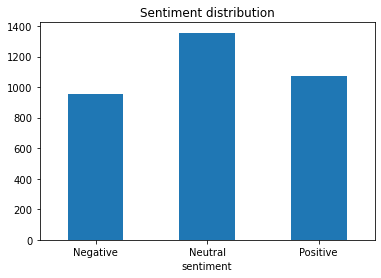

In [9]:
# Display sentiment data distribution
sentiment_text_df = df[['sentiment', 'text']]
ax = sentiment_text_df.groupby('sentiment').count().plot(kind='bar', title='Sentiment distribution', legend=False)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words('english')
word_lemmatizer = WordNetLemmatizer()
tweet_tokenizer = TweetTokenizer(reduce_len=True)

EMAIL_PATTERN = re.compile(
    r'(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)'
)

MENTION_PATTERN = re.compile(r'(^|[^@\w])@(\w{1,15})\b')

HASHTAG_PATTERN = re.compile(r'(^|[^@\w])#(\w{1,15})\b')

URL_PATTERN = re.compile(r'((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)')

NON_ALPHA_PATTERN = re.compile('[^a-zA-Z0-9]')

SEQUENCE_PATTERN = re.compile(r'(.)\1\1+')

SEQUENCE_REPLACE_PATTERN = r'\1\1'


def replace_emails(text):
    return re.sub(EMAIL_PATTERN, ' email', text)


def replace_mentions(text):
    return re.sub(MENTION_PATTERN, ' mention', text)


def replace_hashtags(text):
    return re.sub(HASHTAG_PATTERN, ' hashtag', text)


def replace_urls(text):
    return re.sub(URL_PATTERN, ' URL', text)


def replace_non_alphas(text):
    return re.sub(NON_ALPHA_PATTERN, ' ', text)


def replace_sequences(text):
    return re.sub(SEQUENCE_PATTERN, SEQUENCE_REPLACE_PATTERN, text)


def replace_stop_words(text):
    words = ''
    
    for word in tweet_tokenizer.tokenize(text):
        should_include = True
        for stop_word in stop_words:
            if word in stop_words or not len(word):
                should_include = False
                
        if should_include:
            word = word_lemmatizer.lemmatize(word)
            words += f'{word} '
                
    return words
        
df['text'] = df['text'].map(lambda text: text.lower())
df['text'] = df['text'].map(lambda text: replace_emails(text))
df['text'] = df['text'].map(lambda text: replace_mentions(text))
df['text'] = df['text'].map(lambda text: replace_hashtags(text))
df['text'] = df['text'].map(lambda text: replace_urls(text))
df['text'] = df['text'].map(lambda text: replace_non_alphas(text))
df['text'] = df['text'].map(lambda text: replace_sequences(text))
df['text'] = df['text'].map(lambda text: replace_stop_words(text))

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/szymwisn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/szymwisn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,author_id,author_name,date,emails,hashtags,language,likes,location,mentions,quotes,retweets,sentiment,source,text,time
0,@Acutoronto,Acutoronto,"Mar 27, 2022",NaN,"motivation,acutoronto,acupuncture,tcm,fertilit...",en,0,NaN,NaN,0.0,0.0,positive,LaterMedia,sunday hashtag hashtag hashtag hashtag hashtag...,3:05 PM
1,@LorraineZiff,Lorraine Ziff,"Mar 26, 2022",NaN,"lorraineziff,dearlorraine,smile,friendship,lua...",en,5,NaN,larryziff,0.0,2.0,positive,Twitter for iPhone,luau ready hashtag hashtag mention hashtag has...,3:19 AM
2,@ImpactWellness,Chris Caito,"Mar 27, 2022",NaN,"MuhammadAli,john316,isaiah4031,philippians413,...",en,0,NaN,NaN,0.0,0.0,positive,Twitter for Android,hated every minute training said quit suffer l...,3:02 PM
3,@hiromiyoshihair,Hiro Miyoshi,"Mar 27, 2022",NaN,"mothersday,grateful,thankful",en,0,"London, England",NaN,0.0,0.0,positive,"London, England",mother greateful wishing happiest day hashtag ...,12:55 PM
4,@lunaxbrightwin,Liz lvs Joy,"Mar 27, 2022",NaN,"WildsideOutNow,JOY,RedVelvet",en,6,NaN,RVsmtown0,0.0,0.0,positive,Twitter for Android,joy eres la mujer talentosa que existe red vel...,3:16 PM


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   author_id    3382 non-null   object 
 1   author_name  3382 non-null   object 
 2   date         3382 non-null   object 
 3   emails       0 non-null      float64
 4   hashtags     3332 non-null   object 
 5   language     3382 non-null   object 
 6   likes        3382 non-null   object 
 7   location     133 non-null    object 
 8   mentions     907 non-null    object 
 9   quotes       3382 non-null   float64
 10  retweets     3382 non-null   float64
 11  sentiment    3382 non-null   object 
 12  source       3382 non-null   object 
 13  text         3382 non-null   object 
 14  time         3382 non-null   object 
dtypes: float64(3), object(12)
memory usage: 396.5+ KB


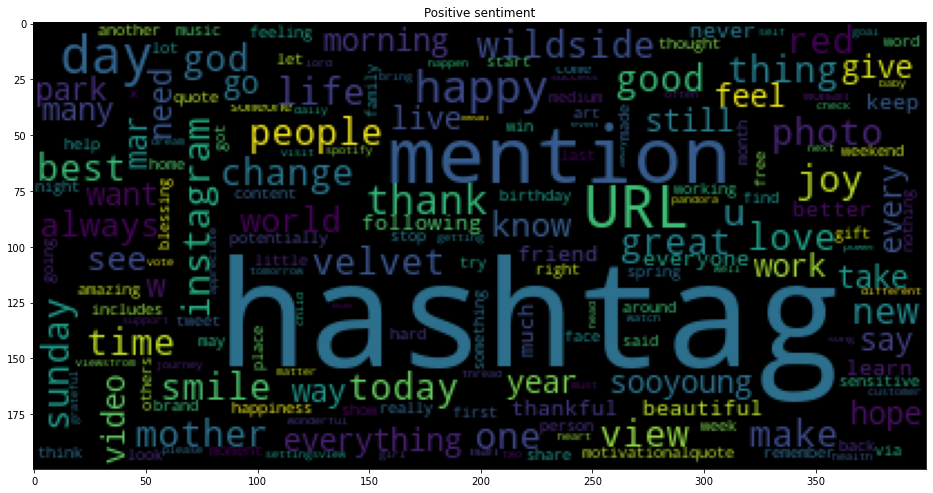

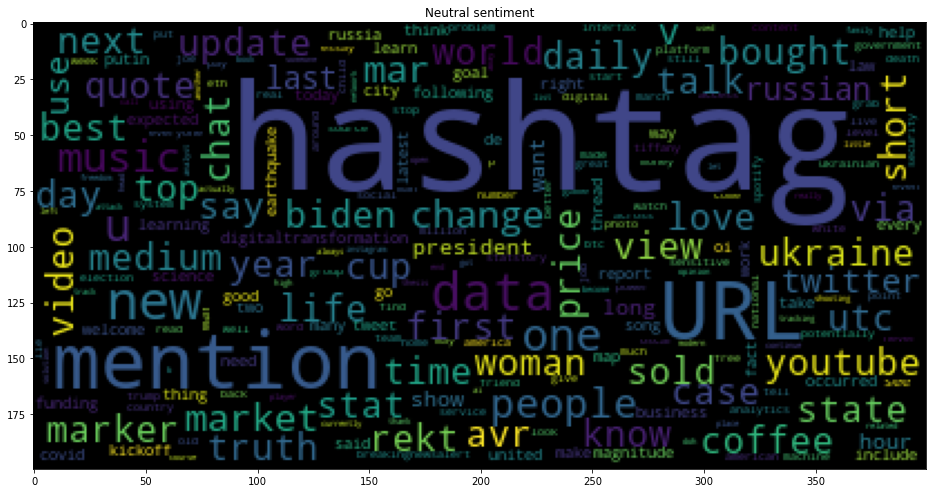

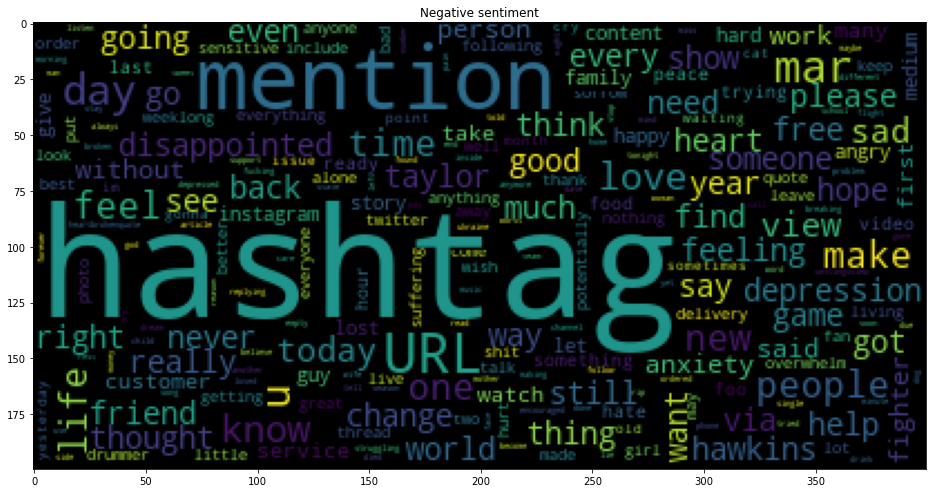

In [12]:
df_positive_text = ' '.join(df.query('sentiment==\'positive\'')['text'])
df_negative_text = ' '.join(df.query('sentiment==\'negative\'')['text'])
df_neutral_text = ' '.join(df.query('sentiment==\'neutral\'')['text'])

def print_word_cloud(title, text):
    plt.figure(figsize=(16, 16))
    wc = WordCloud(max_words=1000, collocations=False).generate(text)
    plt.title(title)
    plt.imshow(wc)
    
# Display word clouds
print_word_cloud('Positive sentiment', df_positive_text)
print_word_cloud('Neutral sentiment', df_neutral_text)
print_word_cloud('Negative sentiment', df_negative_text)